# Code Setup

In [439]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_aruco
import utils_icp
import copy
from utils_data_process import *
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.image as mpimg
from scipy.optimize import curve_fit

data_folder = './data-raw'
# plt.rcParams['mathtext.fontset'] = 'custom'

plt.rcParams['mathtext.default'] = 'regular'  # Use regular text for mathtext by default
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

# Optionally, you can also set the default font family to Arial for consistency
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize_main = 20
fontsize_legend = 14
# import sys
# import importlib
# importlib.reload(sys.modules['utils_data_process'])



In [206]:
def generate_pattern1(start, end, inc):
    # Generate the list starting from start, incrementing by inc to end,
    # then decrementing by inc to start
    result = list(np.arange(start, end + inc, inc)) + list(np.arange(end - inc, start, -inc))
    return np.array(result)

def generate_pattern2(start, end, inc1, inc2):
    result = np.array([], dtype=float)
    for current_val in np.arange(start+inc1, end+inc1, inc1):
        result = np.concatenate((result, generate_pattern1(start, current_val, inc2)))
    return result

generate_pattern1(-20, 20, 1) 


array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1,   0,  -1,  -2,  -3,  -4,
        -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15, -16, -17,
       -18, -19])

# Kinematic Response Actuator 1
Actuator: 1, Tag: 3, Test Case: (-25 -> 0 -> 25 ->0 -> -25) increments of 0.5 psi, n cycles = 5, time per step = 1.5

In [505]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240816_14-09-26_ACTUATOR1",
]

tag_offset_dict = {
    3: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240816_14-09-26_ACTUATOR1/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240816_14-09-26_ACTUATOR1/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240816_14-09-26_ACTUATOR1/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_2', 'camera_3', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


n cycle 5 cycle len 200
fitted circle: x 631.64 y 376.47 r 153.82 sigma 2.44
fitted circle: x -4.22 y 2.93 r 16.27 sigma 0.17
angles 41.82313902861868 113.24669506363621
xc: -4.219841894063945, yc: 2.928042711194797
xc: -4.219841894063945, yc: 2.928042711194797
xc: -4.219841894063945, yc: 2.928042711194797
1501 range of angles 99.91438 -67.163895 32.75049
xc: -4.219841894063945, yc: 2.928042711194797
xc: -4.219841894063945, yc: 2.928042711194797
[[<matplotlib.lines.Line2D object at 0x314e638c0>], [<matplotlib.lines.Line2D object at 0x321d5d400>], [<matplotlib.lines.Line2D object at 0x321d5c920>], [<matplotlib.lines.Line2D object at 0x321d5c950>], [<matplotlib.lines.Line2D object at 0x321d5c620>]]


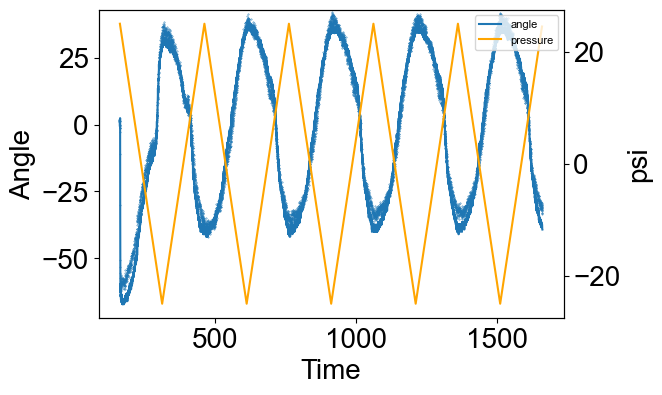

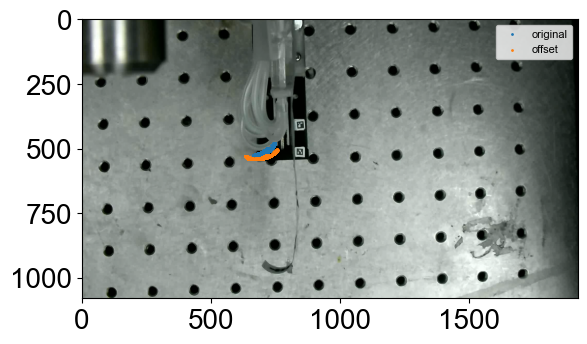

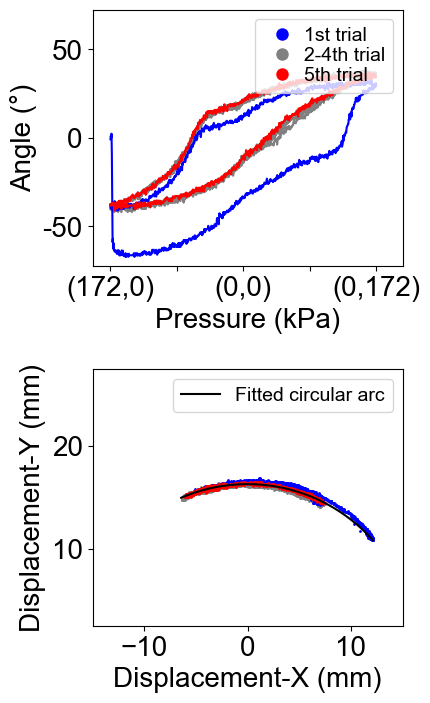

In [510]:
index_of_tag = 0
index_of_actuator = 0
n_cycle = 5 
base_angle = 0

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot, 
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    # ax.legend()
print(lines)
for i, ax in enumerate([ax_angle[0]]):
    ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='upper right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )

for i, ax in enumerate([ax_angle[1]]):
    ax.axis('equal')
    ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    if i == 0:
        ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

# Step Response
Actuator 1, Tag = 3, Test Case = [-25, 0, 25, 0], Number of Cycles = 5, Time Per Step = 20

In [511]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240816_14-45-10_ACTUATOR1_step_response",
]

tag_offset_dict = {
    3: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240816_14-45-10_ACTUATOR1_step_response/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240816_14-45-10_ACTUATOR1_step_response/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240816_14-45-10_ACTUATOR1_step_response/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_3', 'camera_2', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_37', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


fitted circle: x 650.85 y 406.53 r 131.17 sigma 2.57
fitted circle: x -4.01 y 3.55 r 15.36 sigma 0.19
n cycle 5 cycle len 4
new mid 1.5492973


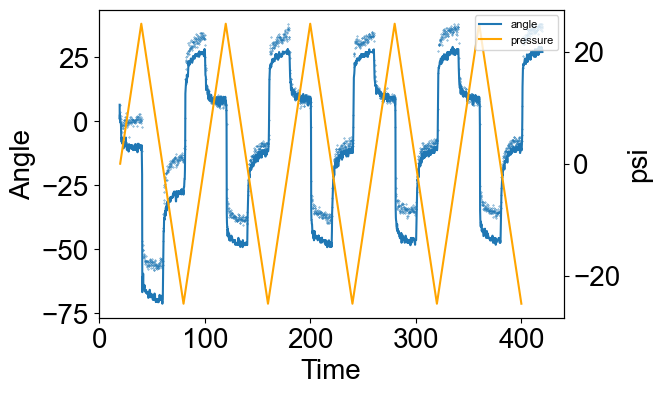

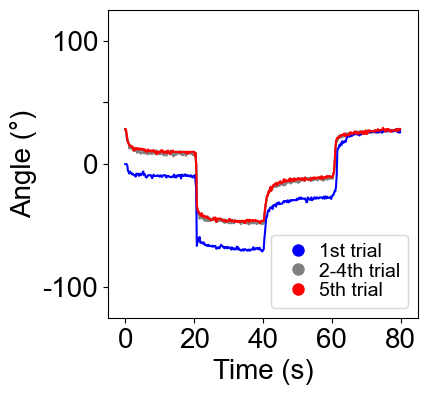

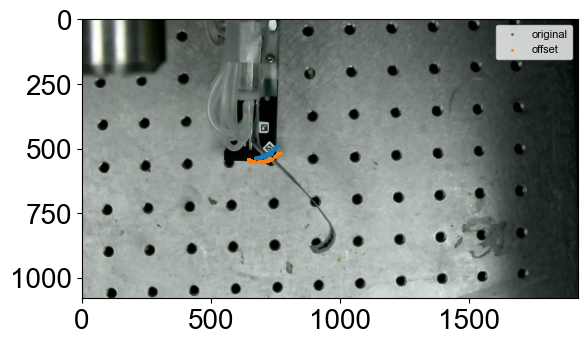

In [503]:
index_of_tag = 0
index_of_actuator = 0
n_cycle = 5
base_angle = 0

fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_angle = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True, gridspec_kw={'wspace': 0.06})
lines = []
fig, ax_img = plt.subplots()
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)
tag_of_desired = tag_mapping[index_of_tag]

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})
    
    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_angle
    # ax1 = axes[1]
    legend_labels = []
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    angle_plot_arr = []
    angle_mid_arr = []
    for i in list(range(1, n_cycle-2))+[0, n_cycle-2] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-2:
            color = 'red'
        else:
            color = 'grey'
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

        
        # if i != 1:
        #     continue
        cur_t = camera_data_dict['t'][tag_of_desired][start_idx:end_idx] - camera_data_dict['t'][tag_of_desired][start_idx]
        cur_angle = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]
        #cur_angle = -cur_angle+90

        if i != 0:
            angle_plot_arr.append(np.copy(cur_angle))
            angle_mid_arr.append(cur_angle[np.argmin(np.abs(cur_t - 20))])
        lines.append(ax.plot(cur_t, 
                cur_angle, 
                linestyle='-',
                label=f'Trial {i+1}',
                color=color
                ))

    #calc_angle_var(angle_plot_arr)
    print('new mid', np.max(angle_mid_arr) - np.min(angle_mid_arr))
for i, ax in enumerate([ax_angle]):

    #ax.set_yticks([0, 25,50,75,100,125])
    #ax.set_yticklabels(['0', '', '50', '','100',''])
    ax.set_xlim(-5, 85)
    ax.set_xticks([0, 20, 40, 60, 80])
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, 50 ,  0, 50 ,  100])
    ax.set_yticklabels(["-100", "", "0", "", "100"])
    
    # ax.set_title(subtitles[i], fontsize='24')
    # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        
        ax.set_ylabel('Angle (°)',)
        ax.set_xlabel('Time (s)')

    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='lower right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )
#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-step.pdf'), dpi=600, bbox_inches = 'tight')
plt.show()


# Kinematic Response Actuator 2
Actuator: 2, Tag: 4, Test Case: (-25 -> 0 -> 25 ->0 -> -25) increments of 0.5 psi, n cycles = 5, time per step = 1.5

In [526]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240816_15-16-09_act2_kinematic",
]

tag_offset_dict = {
    4: {
        'rot': 90,
        'disp': [-3.25, -3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240816_15-16-09_act2_kinematic/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240816_15-16-09_act2_kinematic/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240816_15-16-09_act2_kinematic/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_4', 'camera_5', 'camera_2', 'camera_10', 'camera_3', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_17', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


n cycle 5 cycle len 200
fitted circle: x 712.60 y 523.04 r 116.63 sigma 0.78
fitted circle: x -9.96 y 16.48 r 22.45 sigma 0.19
angles 46.20872666856346 85.72188311255078
xc: -9.956161423292967, yc: 16.483336227863305
xc: -9.956161423292967, yc: 16.483336227863305
xc: -9.956161423292967, yc: 16.483336227863305
1500 range of angles 68.00107 -27.781235 40.219837
xc: -9.956161423292967, yc: 16.483336227863305
xc: -9.956161423292967, yc: 16.483336227863305
[[<matplotlib.lines.Line2D object at 0x309c8c680>], [<matplotlib.lines.Line2D object at 0x309c8ff80>], [<matplotlib.lines.Line2D object at 0x309c8ddf0>], [<matplotlib.lines.Line2D object at 0x309c8e9c0>], [<matplotlib.lines.Line2D object at 0x32c16ab10>]]


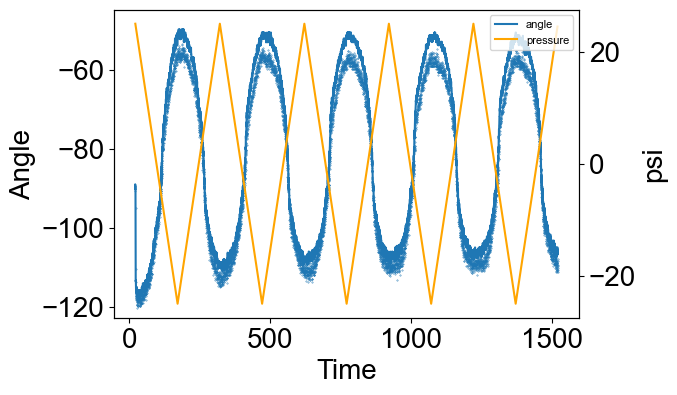

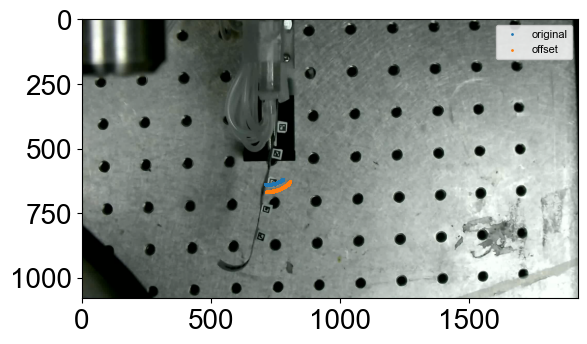

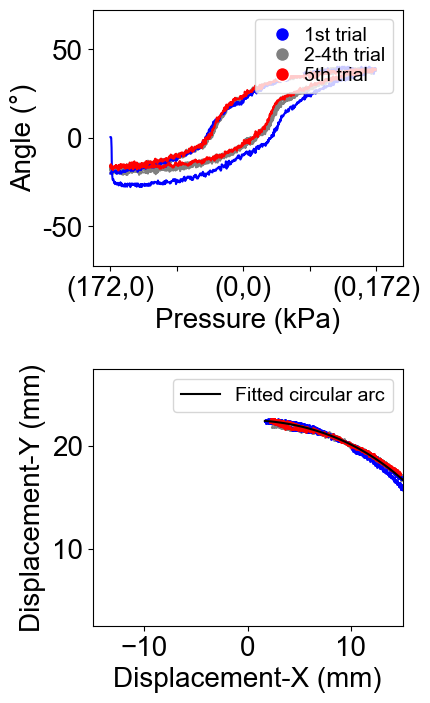

In [527]:
index_of_tag = 1
index_of_actuator = 1
n_cycle = 5 
base_angle = -90

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot, 
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    # ax.legend()
print(lines)
for i, ax in enumerate([ax_angle[0]]):
    ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='upper right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )

for i, ax in enumerate([ax_angle[1]]):
    ax.axis('equal')
    ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    if i == 0:
        ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

In [535]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240816_16-18-39_act3_kinematic",
]

tag_offset_dict = {
    10: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

19516
frame size (1080, 1920, 3)
saving to /Volumes/WD 500GB/test_20240816_16-18-39_act3_kinematic/processed/load_data.pkl
Frame 1 saved as /Volumes/WD 500GB/test_20240816_16-18-39_act3_kinematic/processed/frame_1.png
Frame 1000 saved as /Volumes/WD 500GB/test_20240816_16-18-39_act3_kinematic/processed/frame_1000.png
loaded keys:  ['camera_3', 'camera_5', 'camera_4', 'camera_2', 'camera_10', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE', 'camera_37', 'camera_17']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


n cycle 5 cycle len 200
fitted circle: x 737.02 y 597.04 r 145.77 sigma 3.01
fitted circle: x -2.60 y 35.72 r 18.45 sigma 0.49
angles 43.395593310799754 148.08645699642625
xc: -2.6014246496740805, yc: 35.72171841595864
xc: -2.6014246496740805, yc: 35.72171841595864
xc: -2.6014246496740805, yc: 35.72171841595864
1500 range of angles 143.96065 -45.75009 98.210556
xc: -2.6014246496740805, yc: 35.72171841595864
xc: -2.6014246496740805, yc: 35.72171841595864
[[<matplotlib.lines.Line2D object at 0x33c32b3b0>], [<matplotlib.lines.Line2D object at 0x33c32b260>], [<matplotlib.lines.Line2D object at 0x33c32bf80>], [<matplotlib.lines.Line2D object at 0x33c3296d0>], [<matplotlib.lines.Line2D object at 0x33c32a5a0>]]


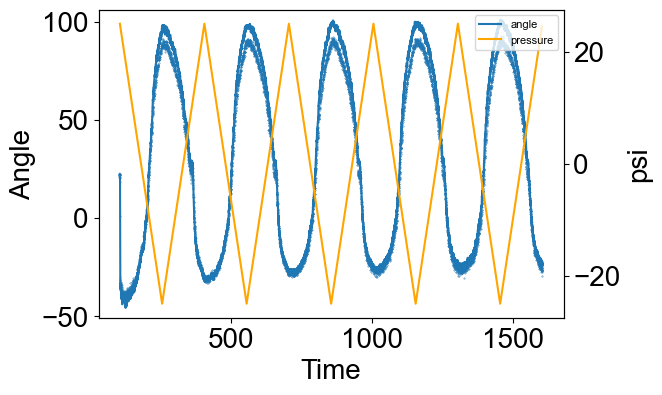

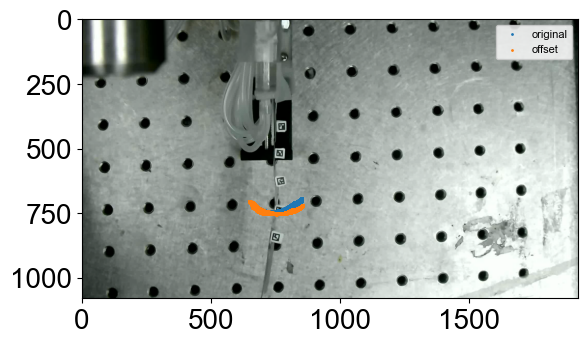

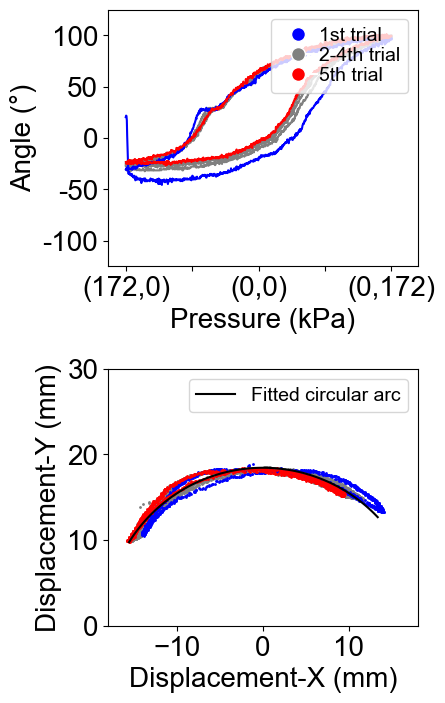

In [539]:
index_of_tag = 2
index_of_actuator = 2
n_cycle = 5 
base_angle = 0

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
                angle_plot, 
                linestyle='-',
                label=f'#{i+1}',
                color=color
                ) #plotting angle vs time
        
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    # ax.legend()
print(lines)
for i, ax in enumerate([ax_angle[0]]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='upper right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )

for i, ax in enumerate([ax_angle[1]]):
    ax.axis('equal')
    ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    if i == 0:
        ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()

In [540]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240816_16-49-27_act_2_step_response",
]

tag_offset_dict = {
    10: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

2248
frame size (1080, 1920, 3)
saving to /Volumes/WD 500GB/test_20240816_16-49-27_act_2_step_response/processed/load_data.pkl
Frame 1 saved as /Volumes/WD 500GB/test_20240816_16-49-27_act_2_step_response/processed/frame_1.png
Frame 1000 saved as /Volumes/WD 500GB/test_20240816_16-49-27_act_2_step_response/processed/frame_1000.png
loaded keys:  ['camera_5', 'camera_4', 'camera_2', 'camera_10', 'camera_3', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'camera_17', 'info_CYCLE_DONE']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


fitted circle: x 756.52 y 648.54 r 97.31 sigma 1.21
fitted circle: x -0.90 y 38.76 r 14.79 sigma 0.27
n cycle 5 cycle len 4
new mid 9.293625


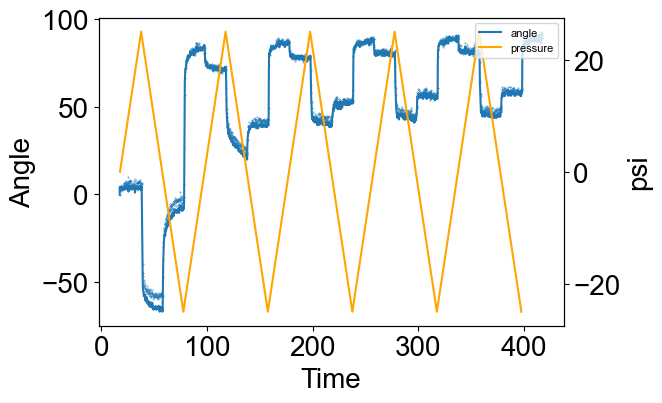

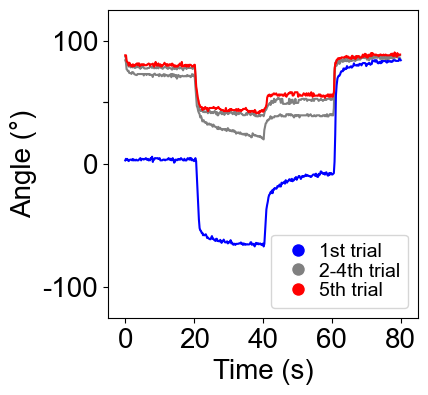

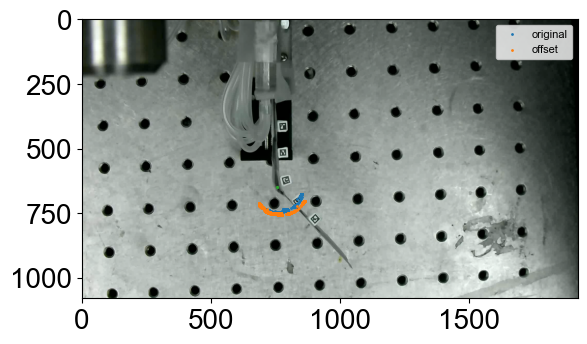

In [541]:
index_of_tag = 2
index_of_actuator = 2
n_cycle = 5
base_angle = 0

fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_angle = plt.subplots(1, 1, figsize=(4,4), sharex=True, sharey=True, gridspec_kw={'wspace': 0.06})
lines = []
fig, ax_img = plt.subplots()
img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)
tag_of_desired = tag_mapping[index_of_tag]

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][1][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})
    
    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)
    
    ax = ax_angle
    # ax1 = axes[1]
    legend_labels = []
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    angle_plot_arr = []
    angle_mid_arr = []
    for i in list(range(1, n_cycle-2))+[0, n_cycle-2] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-2:
            color = 'red'
        else:
            color = 'grey'
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]

        
        # if i != 1:
        #     continue
        cur_t = camera_data_dict['t'][tag_of_desired][start_idx:end_idx] - camera_data_dict['t'][tag_of_desired][start_idx]
        cur_angle = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]
        #cur_angle = -cur_angle+90

        if i != 0:
            angle_plot_arr.append(np.copy(cur_angle))
            angle_mid_arr.append(cur_angle[np.argmin(np.abs(cur_t - 20))])
        lines.append(ax.plot(cur_t, 
                cur_angle, 
                linestyle='-',
                label=f'Trial {i+1}',
                color=color
                ))

    #calc_angle_var(angle_plot_arr)
    print('new mid', np.max(angle_mid_arr) - np.min(angle_mid_arr))
for i, ax in enumerate([ax_angle]):

    #ax.set_yticks([0, 25,50,75,100,125])
    #ax.set_yticklabels(['0', '', '50', '','100',''])
    ax.set_xlim(-5, 85)
    ax.set_xticks([0, 20, 40, 60, 80])
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, 50 ,  0, 50 ,  100])
    ax.set_yticklabels(["-100", "", "0", "", "100"])
    
    # ax.set_title(subtitles[i], fontsize='24')
    # ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        
        ax.set_ylabel('Angle (°)',)
        ax.set_xlabel('Time (s)')

    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='lower right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )
#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-step.pdf'), dpi=600, bbox_inches = 'tight')
plt.show()
